In [6]:
#kernel = use CMIP6 AWS
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
from scipy import stats
import matplotlib
import matplotlib.animation as animation
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import warnings
import matplotlib.path as mpath
import intake
import pandas as pd
import s3fs
import proplot as pplt
from numba import jit
warnings.filterwarnings("ignore")

In [9]:
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')
#query = dict(variable_id = ["rsds","rsus","rlds","rlus","hfss","hfls"], table_id = "Amon",\
#             experiment_id = ['historical', 'ssp585'])
query = dict(variable_id = ["msftmz"],table_id="Omon",\
             experiment_id = ['piControl', 'abrupt-4xCO2'])
res = catalog.search(require_all_on=["source_id"],**query)
models = res.df['source_id'].unique()
print((res.df['source_id'].unique()))
#Other msft* variables aren't available, so this is probably the dataset to use.
#Decent collection of models

['ACCESS-CM2' 'ACCESS-ESM1-5' 'CESM2' 'CESM2-FV2' 'CESM2-WACCM'
 'CESM2-WACCM-FV2' 'CanESM5' 'E3SM-1-0' 'FGOALS-g3' 'GISS-E2-1-G'
 'GISS-E2-2-G' 'INM-CM4-8' 'MIROC6' 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-HR'
 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'SAM0-UNICON']


In [16]:
#set up dictionaries
dict_piC = {}
dict_ab4XCO2 = {}

lats = {}
depth = {}

#set up AWS filesystem access
fs_s3 = s3fs.S3FileSystem(anon=True)
myvars = ["msftmz"] #(time, basin, lev, lat)

for imodel in range(0,len(models)):
    print("piControl, "+models[imodel])
    for ivar in range(0,len(myvars)):
        res = catalog.search(source_id=models[imodel], variable_id=myvars[ivar],\
                             experiment_id="piControl", table_id="Omon")
        #print(res.df['zstore'][0])
        mapper = fs_s3.get_mapper(res.df['zstore'][0])
        ds = xr.open_zarr(mapper, consolidated=True)
        try:
            lats[models[imodel]] = ds.lat
            depth[models[imodel]] = ds.lev
        except:
            print("Latitude or depth error")
        try:
            dict_piC[models[imodel]+"_"+myvars[ivar]]=ds[myvars[ivar]].isel(basin=0)
        except (AttributeError, KeyError):
            print(myvars[ivar]+" not found")
    print("abrupt-4xCO2, "+models[imodel])
    for ivar in range(0,len(myvars)):
        res = catalog.search(source_id=models[imodel], variable_id=myvars[ivar],\
                             experiment_id="abrupt-4xCO2", table_id="Omon")
        #print(res.df['zstore'][0])
        mapper = fs_s3.get_mapper(res.df['zstore'][0])
        ds = xr.open_zarr(mapper, consolidated=True)
        #print(ds.time)
        try: #time slice from 120*12 to 150*12
            dict_ab4XCO2[models[imodel]+"_"+myvars[ivar]]=ds[myvars[ivar]].isel(basin=0, time=slice(1440,1800))
        except:
            print(myvars[ivar]+" not found")

piControl, ACCESS-CM2
abrupt-4xCO2, ACCESS-CM2
piControl, ACCESS-ESM1-5
abrupt-4xCO2, ACCESS-ESM1-5
piControl, CESM2
abrupt-4xCO2, CESM2
piControl, CESM2-FV2
abrupt-4xCO2, CESM2-FV2
piControl, CESM2-WACCM
abrupt-4xCO2, CESM2-WACCM
piControl, CESM2-WACCM-FV2
abrupt-4xCO2, CESM2-WACCM-FV2
piControl, CanESM5
abrupt-4xCO2, CanESM5
piControl, E3SM-1-0
abrupt-4xCO2, E3SM-1-0
piControl, FGOALS-g3
abrupt-4xCO2, FGOALS-g3
piControl, GISS-E2-1-G
abrupt-4xCO2, GISS-E2-1-G
piControl, GISS-E2-2-G
abrupt-4xCO2, GISS-E2-2-G
piControl, INM-CM4-8
abrupt-4xCO2, INM-CM4-8
piControl, MIROC6
abrupt-4xCO2, MIROC6
piControl, MPI-ESM-1-2-HAM
abrupt-4xCO2, MPI-ESM-1-2-HAM
piControl, MPI-ESM1-2-HR
abrupt-4xCO2, MPI-ESM1-2-HR
piControl, MPI-ESM1-2-LR
abrupt-4xCO2, MPI-ESM1-2-LR
piControl, MRI-ESM2-0
abrupt-4xCO2, MRI-ESM2-0
piControl, SAM0-UNICON
abrupt-4xCO2, SAM0-UNICON


In [19]:
piC_mean = {}
ab4XCO2_mean = {}
#(time, lev, lat)

for i in enumerate(models):
    print("Working on "+i[1])
    piC_mean[i[1]+"_msftmz"] = np.array(dict_piC[i[1]+"_msftmz"].mean(axis=0))
    ab4XCO2_mean[i[1]+"_msftmz"] = np.array(dict_ab4XCO2[i[1]+"_msftmz"].mean(axis=0))

Working on ACCESS-CM2
Working on ACCESS-ESM1-5
Working on CESM2
Working on CESM2-FV2
Working on CESM2-WACCM
Working on CESM2-WACCM-FV2
Working on CanESM5
Working on E3SM-1-0
Working on FGOALS-g3
Working on GISS-E2-1-G
Working on GISS-E2-2-G
Working on INM-CM4-8
Working on MIROC6
Working on MPI-ESM-1-2-HAM
Working on MPI-ESM1-2-HR
Working on MPI-ESM1-2-LR
Working on MRI-ESM2-0
Working on SAM0-UNICON


In [30]:
print(dict_piC["CESM2_msftmz"].lev) #in kg/s
#Correct levs for CESM models
CESM_mods = ['CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2']
#only run below code 1X!!
#for i in enumerate(CESM_mods):
#    depth[i[1]] = depth[i[1]]/100.
#    print(depth[i[1]])

<xarray.DataArray 'lev' (lev: 61)>
array([     0.      ,   1000.      ,   2000.      ,   3000.      ,
         4000.      ,   5000.      ,   6000.      ,   7000.      ,
         8000.      ,   9000.      ,  10000.      ,  11000.      ,
        12000.      ,  13000.      ,  14000.      ,  15000.      ,
        16000.      ,  17019.681641,  18076.128906,  19182.125   ,
        20349.931641,  21592.34375 ,  22923.3125  ,  24358.453125,
        25915.580078,  27615.259766,  29481.470703,  31542.373047,
        33831.226562,  36387.472656,  39258.046875,  42498.886719,
        46176.65625 ,  50370.6875  ,  55174.910156,  60699.667969,
        67072.859375,  74439.804688,  82960.695312,  92804.351562,
       104136.820312, 117104.015625, 131809.359375, 148290.078125,
       166499.203125, 186301.4375  , 207487.390625, 229803.90625 ,
       252990.40625 , 276809.84375 , 301067.0625  , 325613.84375 ,
       350344.875   , 375189.1875  , 400101.15625 , 425052.46875 ,
       450026.0625  , 47501

[array([3.220000e+03, 1.383880e+05, 7.061210e+05, 3.936720e+06,
        4.371985e+07, 1.043160e+07, 1.456599e+06, 3.918630e+05,
        5.279500e+04, 2.844000e+03])
 array([-1.0971364e+08, -8.5553480e+07, -6.1393320e+07, -3.7233160e+07,
        -1.3073000e+07,  1.1087160e+07,  3.5247320e+07,  5.9407480e+07,
         8.3567640e+07,  1.0772780e+08,  1.3188796e+08], dtype=float32)
 <BarContainer object of 10 artists>]


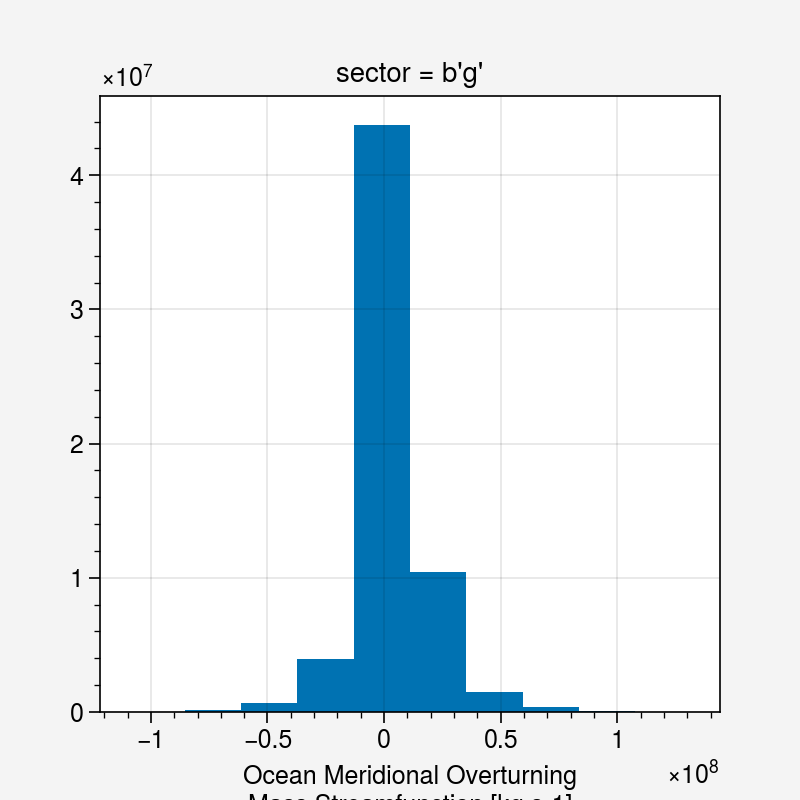

In [38]:
print(np.array(dict_piC["E3SM-1-0_msftmz"].plot()))

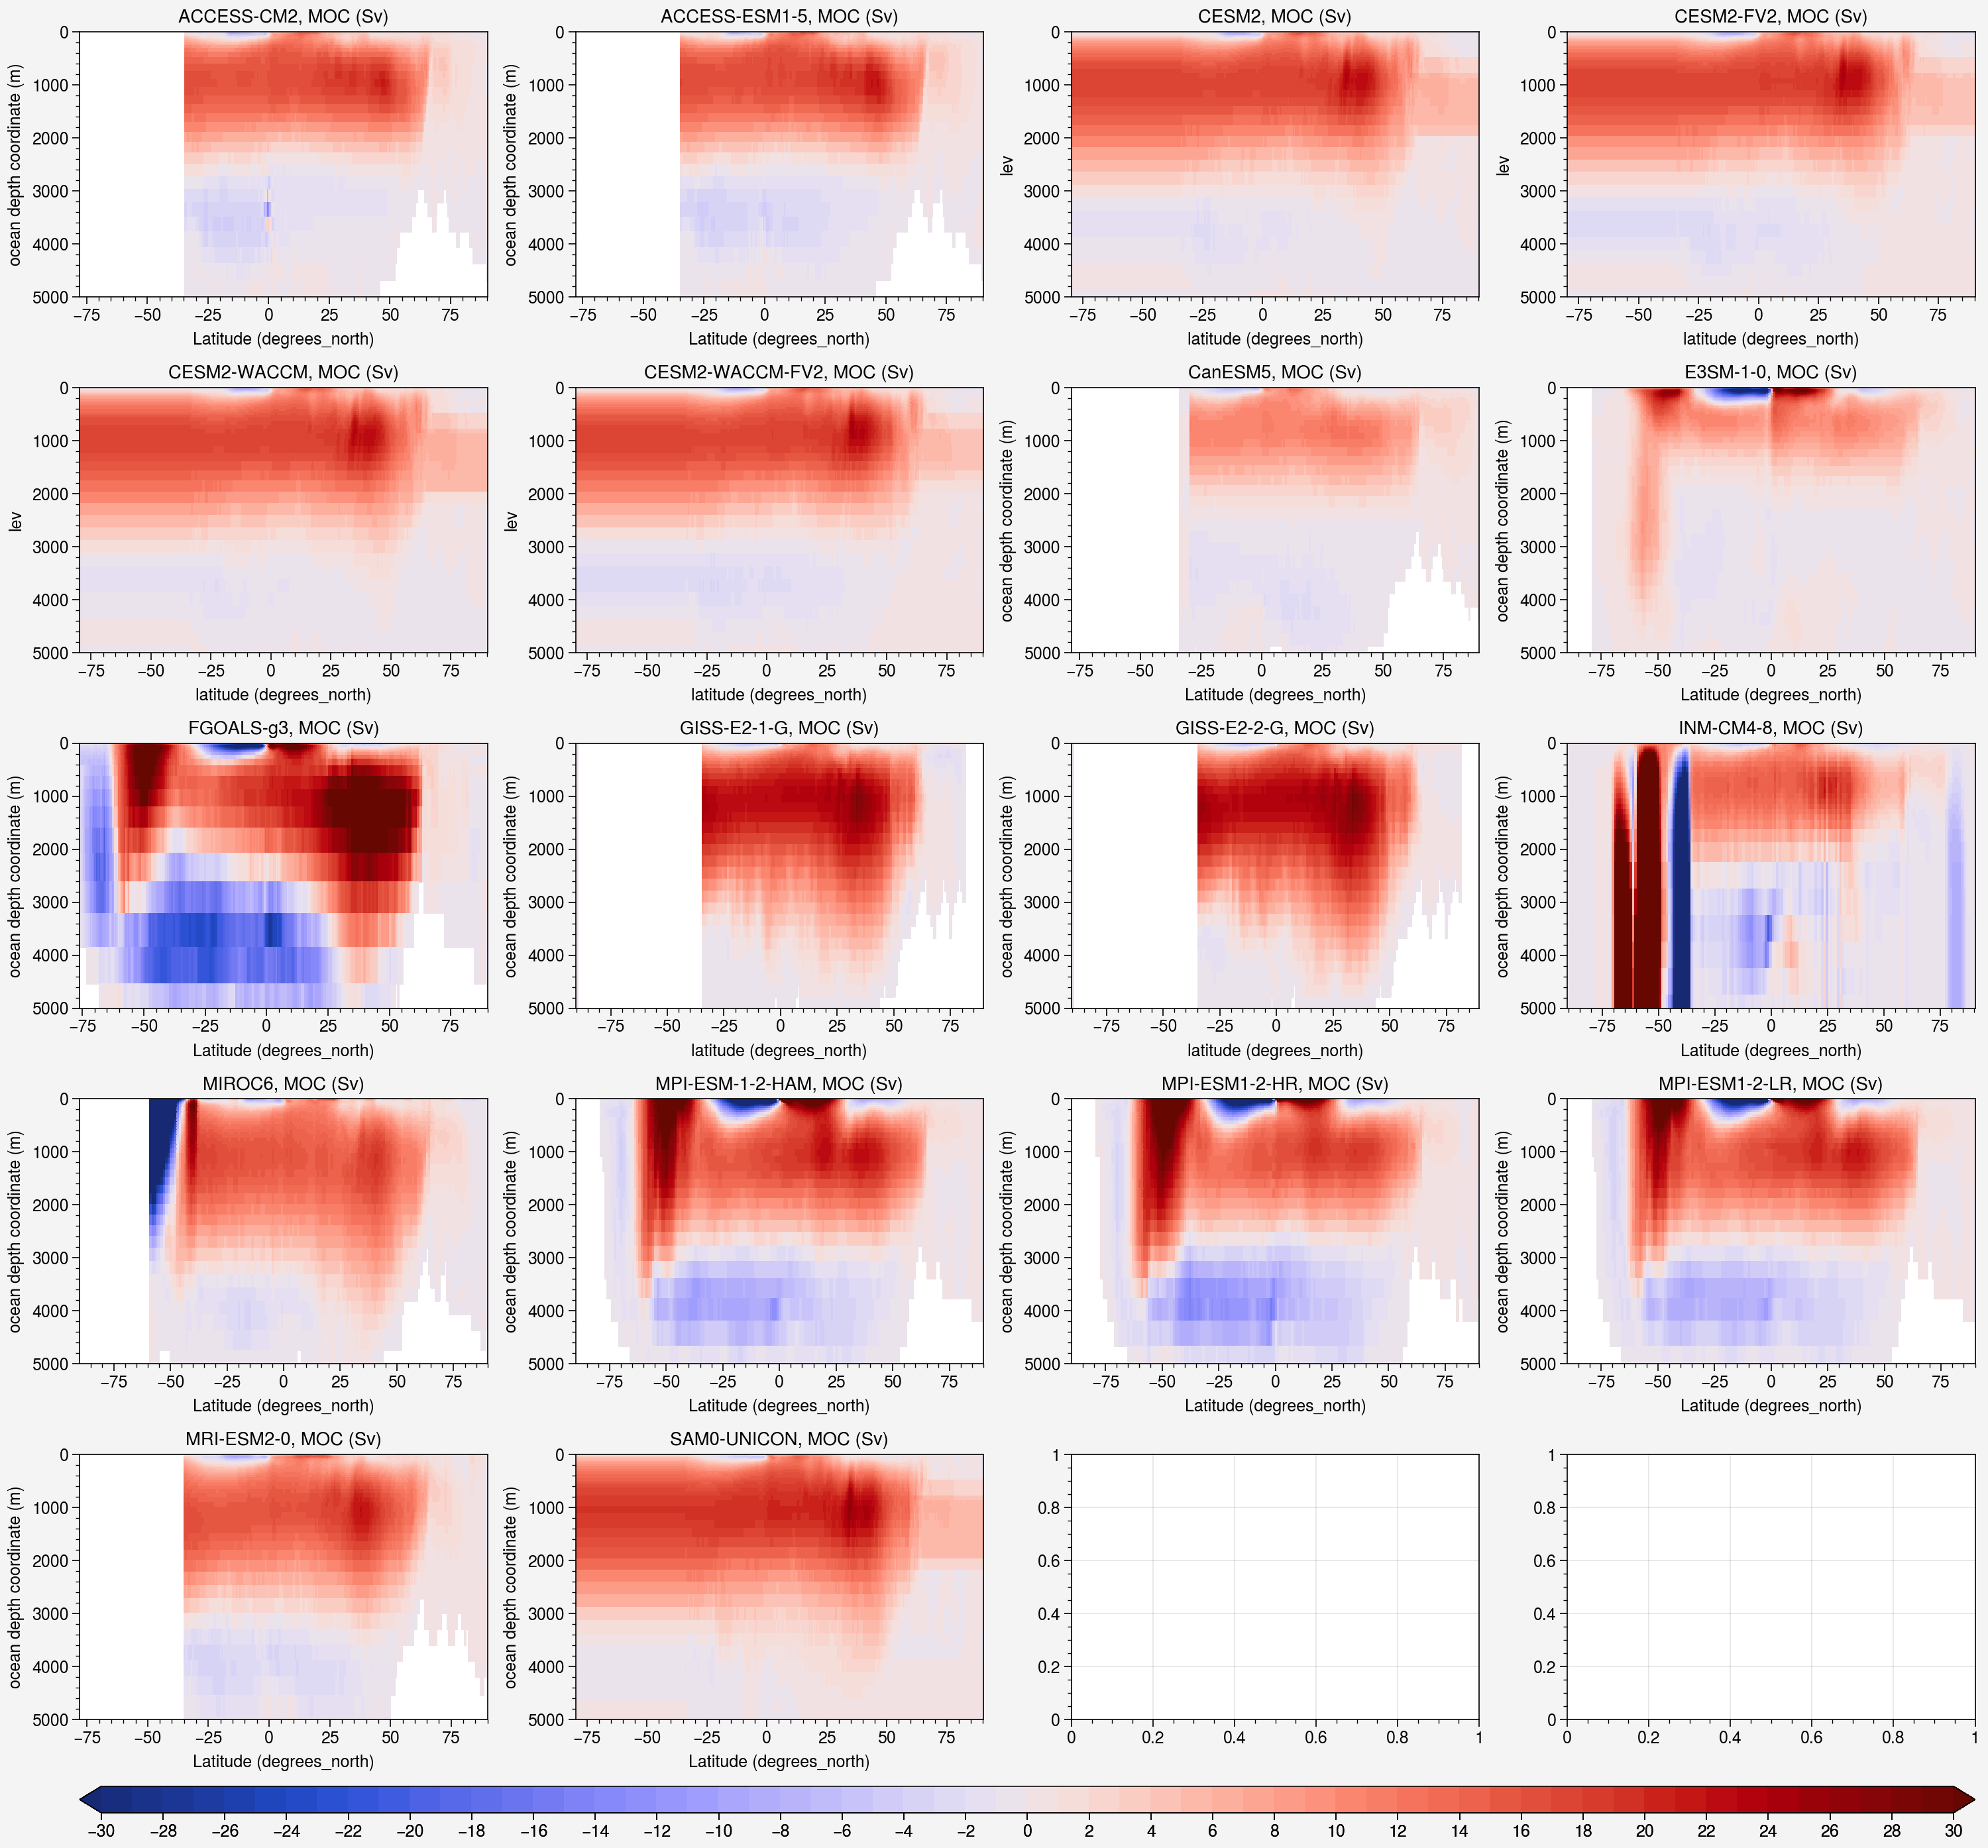

In [42]:
#Postage Stamp Figure
myField=", MOC (Sv)"
fig, axs = pplt.subplots(ncols=4, nrows=5, figwidth=15, refwidth=4, refheight=2, share=False)
myconts = np.linspace(-30.,30.,61)
Sv_conv = 1.e-9 #conversion to Sv from kg/s

for i in enumerate(models):
    axs[i[0]].format(title=i[1]+myField,ylim=(5000,0))
    if i[1]=="E3SM-1-0": #units are in m3/sec rather than kg/sec, as claimed
        m=axs[i[0]].pcolormesh(lats[i[1]], depth[i[1]], 1000.*Sv_conv*piC_mean[i[1]+"_msftmz"], levels=myconts,\
                               cmap="BR", extend="both")
    else:
        m=axs[i[0]].pcolormesh(lats[i[1]], depth[i[1]], Sv_conv*piC_mean[i[1]+"_msftmz"], levels=myconts,\
                               cmap="BR", extend="both")
fig.colorbar(m,loc="b")
plt.savefig("CMIP6_MOC_postagestamps_piC_052022.pdf")

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

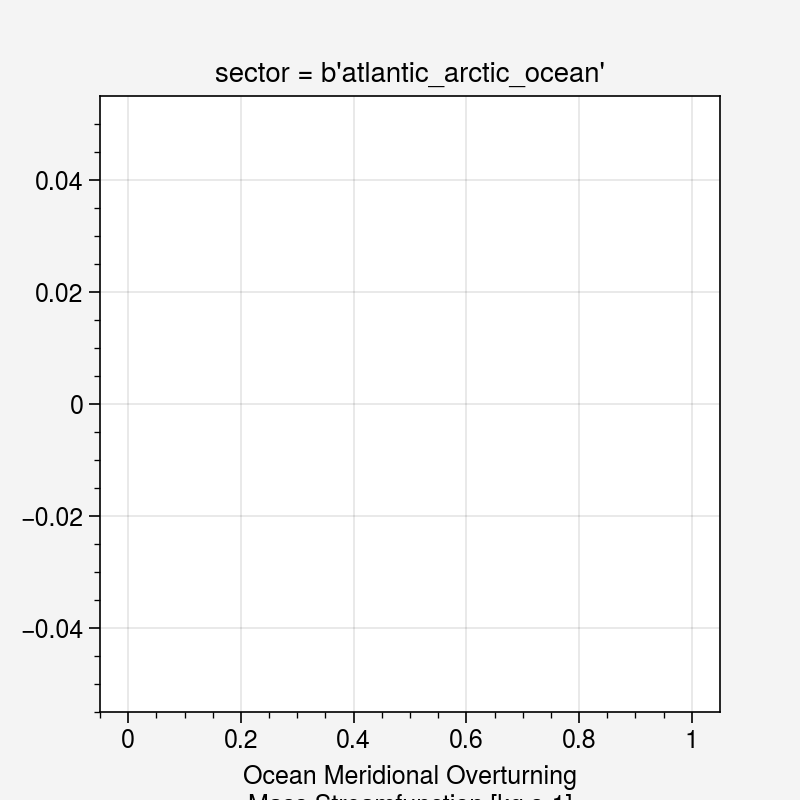

In [47]:
dict_ab4XCO2["MRI-ESM2-0_msftmz"].plot()

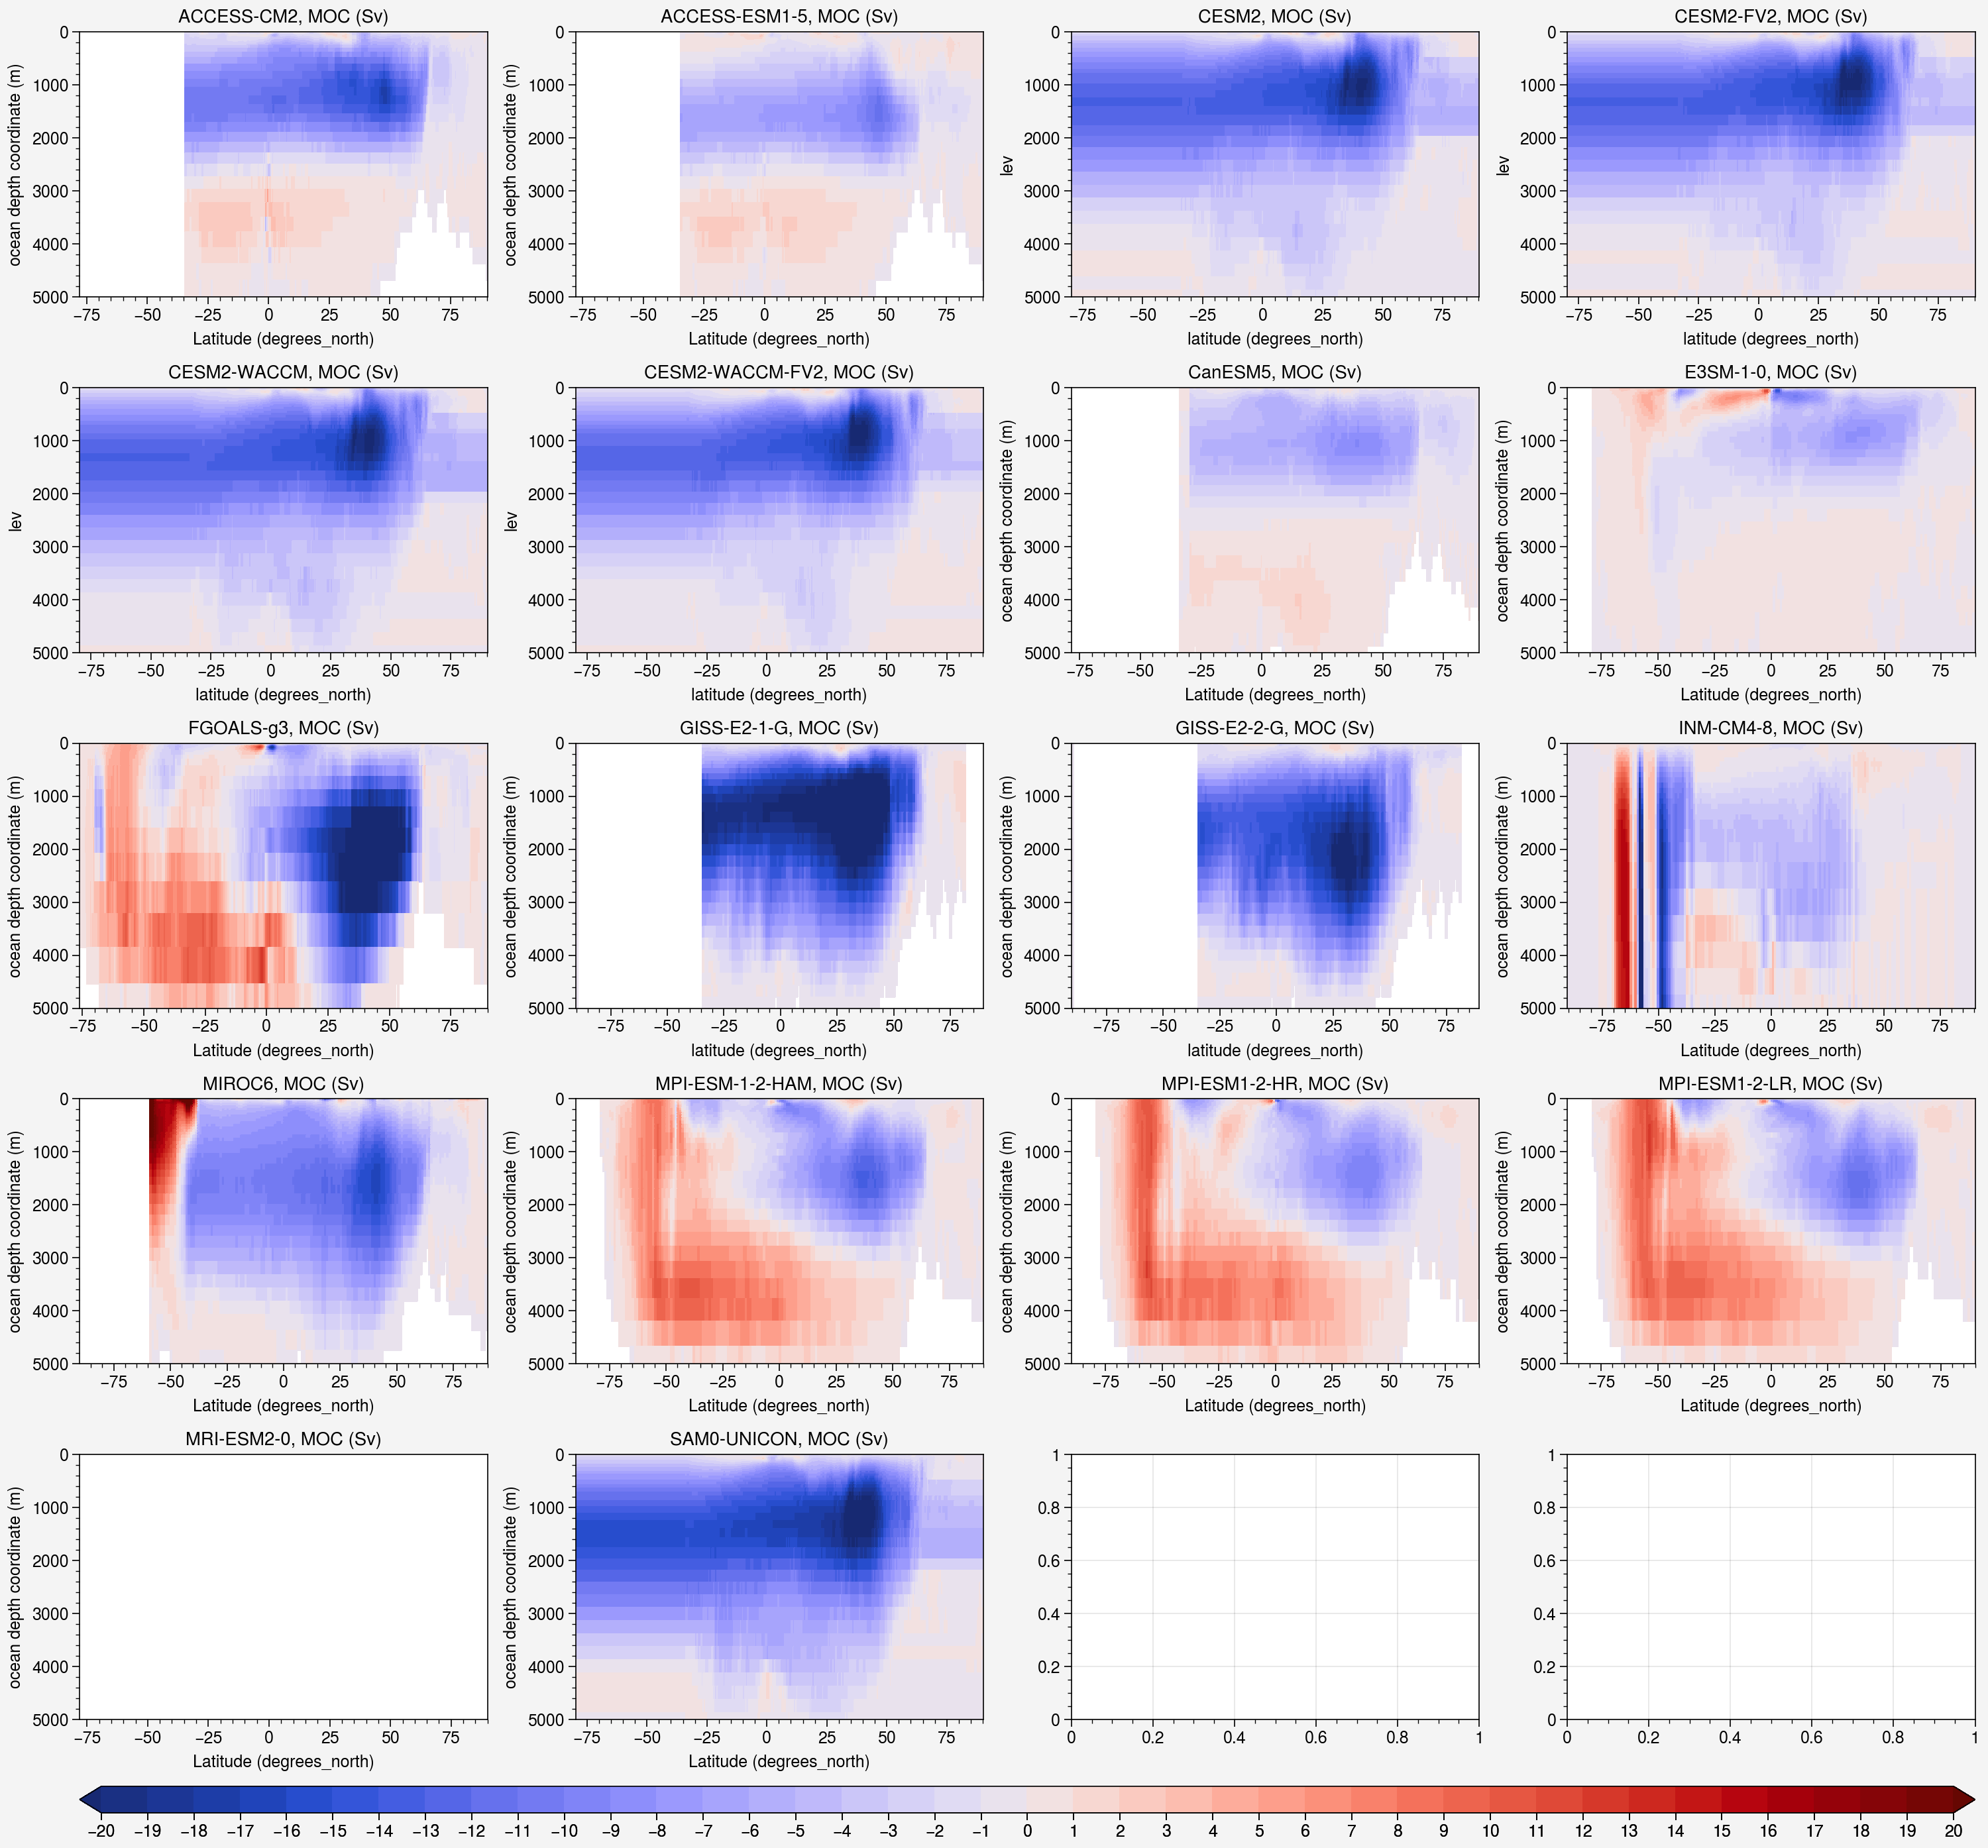

In [45]:
#Postage Stamp Figure
myField=", MOC (Sv)"
fig, axs = pplt.subplots(ncols=4, nrows=5, figwidth=15, refwidth=4, refheight=2, share=False)
myconts = np.linspace(-20.,20.,41)
Sv_conv = 1.e-9 #conversion to Sv from kg/s

for i in enumerate(models):
    axs[i[0]].format(title=i[1]+myField,ylim=(5000,0))
    if i[1]=="E3SM-1-0": #units are in m3/sec rather than kg/sec, as claimed
        m=axs[i[0]].pcolormesh(lats[i[1]], depth[i[1]], \
                               Sv_conv*ab4XCO2_mean[i[1]+"_msftmz"]-1000.*Sv_conv*piC_mean[i[1]+"_msftmz"],\
                               levels=myconts,\
                               cmap="BR", extend="both")
    else:
        m=axs[i[0]].pcolormesh(lats[i[1]], depth[i[1]], Sv_conv*(ab4XCO2_mean[i[1]+"_msftmz"]-piC_mean[i[1]+"_msftmz"]),\
                               levels=myconts,\
                               cmap="BR", extend="both")
fig.colorbar(m,loc="b")
plt.savefig("CMIP6_MOC_postagestamps_ab4XCO2-piC_052022.pdf")

In [68]:
AMOCind_piC = {}
AMOCind_ab4XCO2 = {}
for i in enumerate(models):
    latmod = lats[i[1]]
    depthmod = depth[i[1]]
    latmesh, depthmesh = np.meshgrid(latmod, depthmod)
    #print(latmesh)
    #print(depthmesh)
    MOCmod_piC = piC_mean[i[1]+"_msftmz"]
    MOCmod_ab4XCO2 = ab4XCO2_mean[i[1]+"_msftmz"]
    MOCmod_piC = np.where(np.isnan(MOCmod_piC),0.,MOCmod_piC)
    MOCmod_ab4XCO2 = np.where(np.isnan(MOCmod_ab4XCO2),0.,MOCmod_ab4XCO2)
    if i[1]=="E3SM-1-0":
        MOCmod_piC = MOCmod_piC*1.e-6
    else:
        MOCmod_piC = MOCmod_piC*1.e-9
    MOCmod_ab4XCO2 = MOCmod_ab4XCO2*1.e-9
    myMask = np.where((latmesh>30.)&(latmesh<70.)&(depthmesh>300.)&(depthmesh<2000.), 1., 0.)
    AMOCind_piC[i[1]] = np.max(MOCmod_piC*myMask)
    print(AMOCind_piC[i[1]])
    inds = np.unravel_index((MOCmod_piC*myMask).argmax(),np.shape(MOCmod_piC))
    AMOCind_ab4XCO2[i[1]] = MOCmod_ab4XCO2[inds]
    print(AMOCind_ab4XCO2[i[1]])

21.149433135986328
4.565773
22.18338966369629
13.39798
23.509456634521484
3.1975245
24.58207130432129
3.3787622
23.459991455078125
3.239577
25.281383514404297
3.2896655
12.897649765014648
5.002213
11.525097846984863
4.317711
38.86310577392578
21.45485
28.529985427856445
1.2350827
29.302061080932617
12.094693
19.29173469543457
16.580452
19.18756675720215
3.2789207
22.989845275878906
11.357359
19.03580093383789
10.138441
22.12267303466797
12.941493
22.046485900878906
0.0
27.588048934936523
3.7256536


In [73]:
#Calc dOHU
#Use netcdf files to load dOHU
dict_dOHU = {}
lats_OHU = {}
mydir = "/net/aeolus/aura/hansingh/CMIP6AWS_data_processed/"

for i in enumerate(models):
    imod = i[1]
    print("Working on "+imod)
    try:
        OHU_C = xr.open_dataset(mydir+"rsds."+imod+".piControl.nc").rsds-xr.open_dataset(mydir+"rsus."+imod+".piControl.nc").rsus+\
                xr.open_dataset(mydir+"rlds."+imod+".piControl.nc").rlds-xr.open_dataset(mydir+"rlus."+imod+".piControl.nc").rlus-\
                xr.open_dataset(mydir+"hfss."+imod+".piControl.nc").hfss-xr.open_dataset(mydir+"hfls."+imod+".piControl.nc").hfls
        OHU_E = xr.open_dataset(mydir+"rsds."+imod+".abrupt4XCO2.nc").rsds-xr.open_dataset(mydir+"rsus."+imod+".abrupt4XCO2.nc").rsus+\
                xr.open_dataset(mydir+"rlds."+imod+".abrupt4XCO2.nc").rlds-xr.open_dataset(mydir+"rlus."+imod+".abrupt4XCO2.nc").rlus-\
                xr.open_dataset(mydir+"hfss."+imod+".abrupt4XCO2.nc").hfss-xr.open_dataset(mydir+"hfls."+imod+".abrupt4XCO2.nc").hfls
        dict_dOHU[imod] = (OHU_E-OHU_C).squeeze()
        lats_OHU[imod] = xr.open_dataset(mydir+"rsds."+imod+".piControl.nc").lat
    except:
        print("**Model not found.")
        
#Calculate OHU indices
#Calculate Heat Uptake Indices
#Calculate global mean and regional heat uptake
dict_GM_OHU_anom = {}
dict_SHext_OHU_anom = {}
dict_NHext_OHU_anom = {}
deg2rad = np.pi/180.
modellist = []

for i in enumerate(models):
    imod = i[1]
    try:
        mylat = np.array(lats_OHU[imod])
        print(imod)
        coslat = np.cos(deg2rad*mylat)
        coslat_SHext = np.where(mylat<-50.,coslat,0.)
        coslat_NHext = np.where(mylat>50.,coslat,0.)
        mydOHU = dict_dOHU[imod]
        dict_GM_OHU_anom[imod] = np.nansum(np.mean(mydOHU, axis=1)*coslat)/np.nansum(coslat)
        dict_SHext_OHU_anom[imod] = np.nansum(np.mean(mydOHU, axis=1)*coslat_SHext)/np.nansum(coslat_SHext)
        dict_NHext_OHU_anom[imod] = np.nansum(np.mean(mydOHU, axis=1)*coslat_NHext)/np.nansum(coslat_NHext)
        modellist.append(imod)
    except:
        print("**Not found.")
print(modellist)  

Working on ACCESS-CM2
Working on ACCESS-ESM1-5
Working on CESM2
Working on CESM2-FV2
Working on CESM2-WACCM
Working on CESM2-WACCM-FV2
Working on CanESM5
Working on E3SM-1-0
Working on FGOALS-g3
Working on GISS-E2-1-G
Working on GISS-E2-2-G
Working on INM-CM4-8
Working on MIROC6
Working on MPI-ESM-1-2-HAM
Working on MPI-ESM1-2-HR
Working on MPI-ESM1-2-LR
Working on MRI-ESM2-0
**Model not found.
Working on SAM0-UNICON
ACCESS-CM2
ACCESS-ESM1-5
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
CanESM5
E3SM-1-0
FGOALS-g3
GISS-E2-1-G
GISS-E2-2-G
INM-CM4-8
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
**Not found.
SAM0-UNICON
['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CanESM5', 'E3SM-1-0', 'FGOALS-g3', 'GISS-E2-1-G', 'GISS-E2-2-G', 'INM-CM4-8', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'SAM0-UNICON']


In [88]:
print(modellist)
#use modellist to make some 1D arrays
myAMOCpiC = np.zeros([len(modellist)])
mydAMOC = np.zeros([len(modellist)])
mydAMOCperc = np.zeros([len(modellist)])
mydOHU_NH = np.zeros([len(modellist)])
mydOHU_SH = np.zeros([len(modellist)])
mydOHU_glob = np.zeros([len(modellist)])
for i in enumerate(modellist):
    mydOHU_NH[i[0]] = dict_NHext_OHU_anom[i[1]]
    mydOHU_SH[i[0]] = dict_SHext_OHU_anom[i[1]]
    mydOHU_glob[i[0]] = dict_GM_OHU_anom[i[1]]
    AMOC_piC = AMOCind_piC[i[1]]
    myAMOCpiC[i[0]] = AMOC_piC
    AMOC_ab4XCO2 = AMOCind_ab4XCO2[i[1]]
    mydAMOC[i[0]] = AMOC_ab4XCO2-AMOC_piC
    mydAMOCperc[i[0]] = 100.*(AMOC_ab4XCO2-AMOC_piC)/AMOC_piC

['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CanESM5', 'E3SM-1-0', 'FGOALS-g3', 'GISS-E2-1-G', 'GISS-E2-2-G', 'INM-CM4-8', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'SAM0-UNICON']


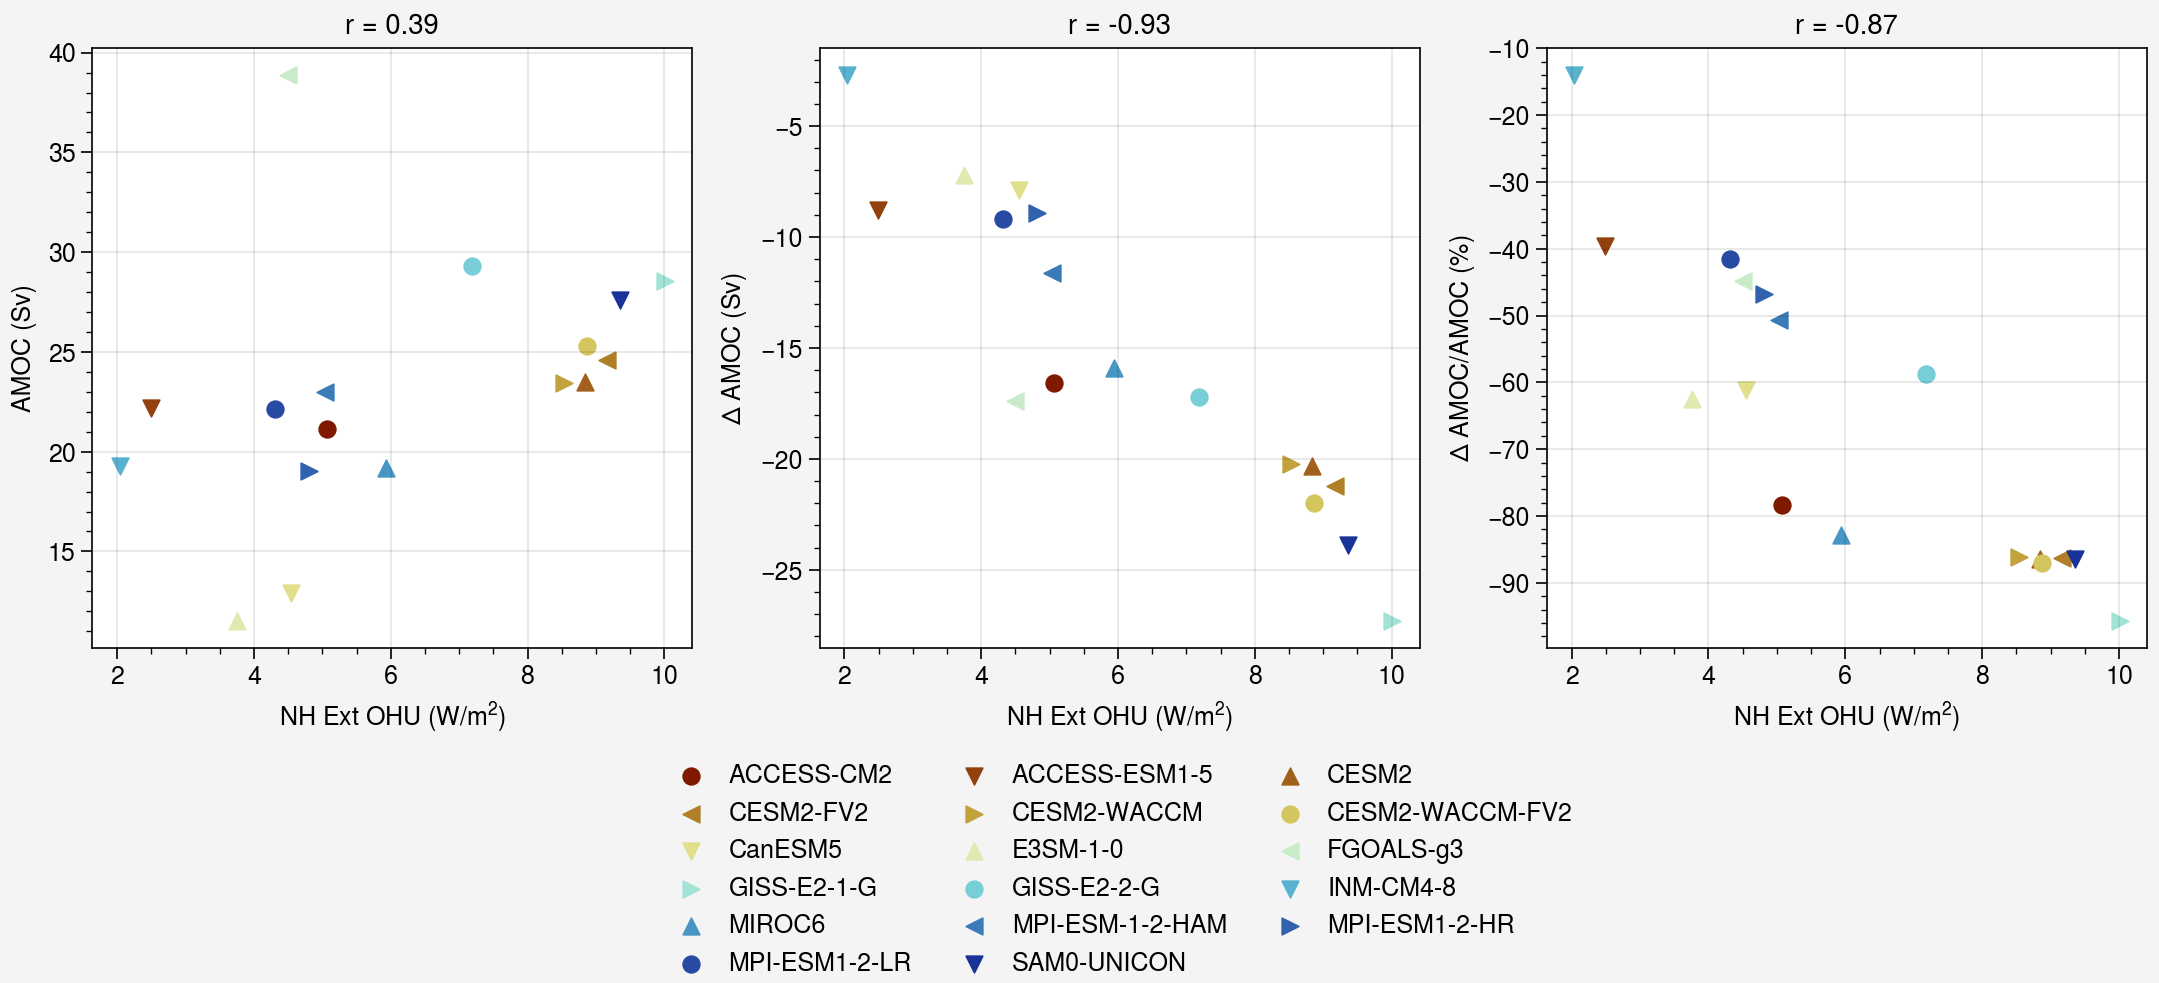

In [87]:
#Make some scatters
fig = pplt.figure(refwidth=3., refaspect=(3, 3), share=False)
cycle = pplt.Cycle('roma', len(modellist), marker=['o','v','^','<','>'])
slope0, intercept0, r_value0, p_value, std_err = scipy.stats.linregress(mydOHU_NH, myAMOCpiC)
slope1, intercept1, r_value1, p_value, std_err = scipy.stats.linregress(mydOHU_NH, mydAMOC)
slope2, intercept2, r_value2, p_value, std_err = scipy.stats.linregress(mydOHU_NH, mydAMOCperc)

ax0 = fig.subplot(131)
ax1 = fig.subplot(132)
ax2 = fig.subplot(133)
for i in enumerate(modellist):
    dOHU_NH = dict_NHext_OHU_anom[i[1]]
    AMOC_piC = AMOCind_piC[i[1]]
    AMOC_ab4XCO2 = AMOCind_ab4XCO2[i[1]]
    dAMOC = AMOC_ab4XCO2-AMOC_piC
    dAMOCperc = 100.*dAMOC/AMOC_piC
    ax0.scatter(dOHU_NH, AMOC_piC, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]], label=i[1])
    ax1.scatter(dOHU_NH, dAMOC, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]])
    ax2.scatter(dOHU_NH, dAMOCperc, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]])

ax0.format(ylabel="AMOC (Sv)",xlabel="NH Ext OHU (W/m$^2$)", title="r = "+str(np.round(r_value0,2)))
ax1.format(ylabel="$\Delta$ AMOC (Sv)",xlabel="NH Ext OHU (W/m$^2$)", title="r = "+str(np.round(r_value1,2)))
ax2.format(ylabel="$\Delta$ AMOC/AMOC (%)",xlabel="NH Ext OHU (W/m$^2$)", title="r = "+str(np.round(r_value2,2)))

fig.legend(ncols=3, frame=False, loc='b')
plt.savefig("CMIP6_NHextOHU_AMOC_Scatter_052022.pdf")

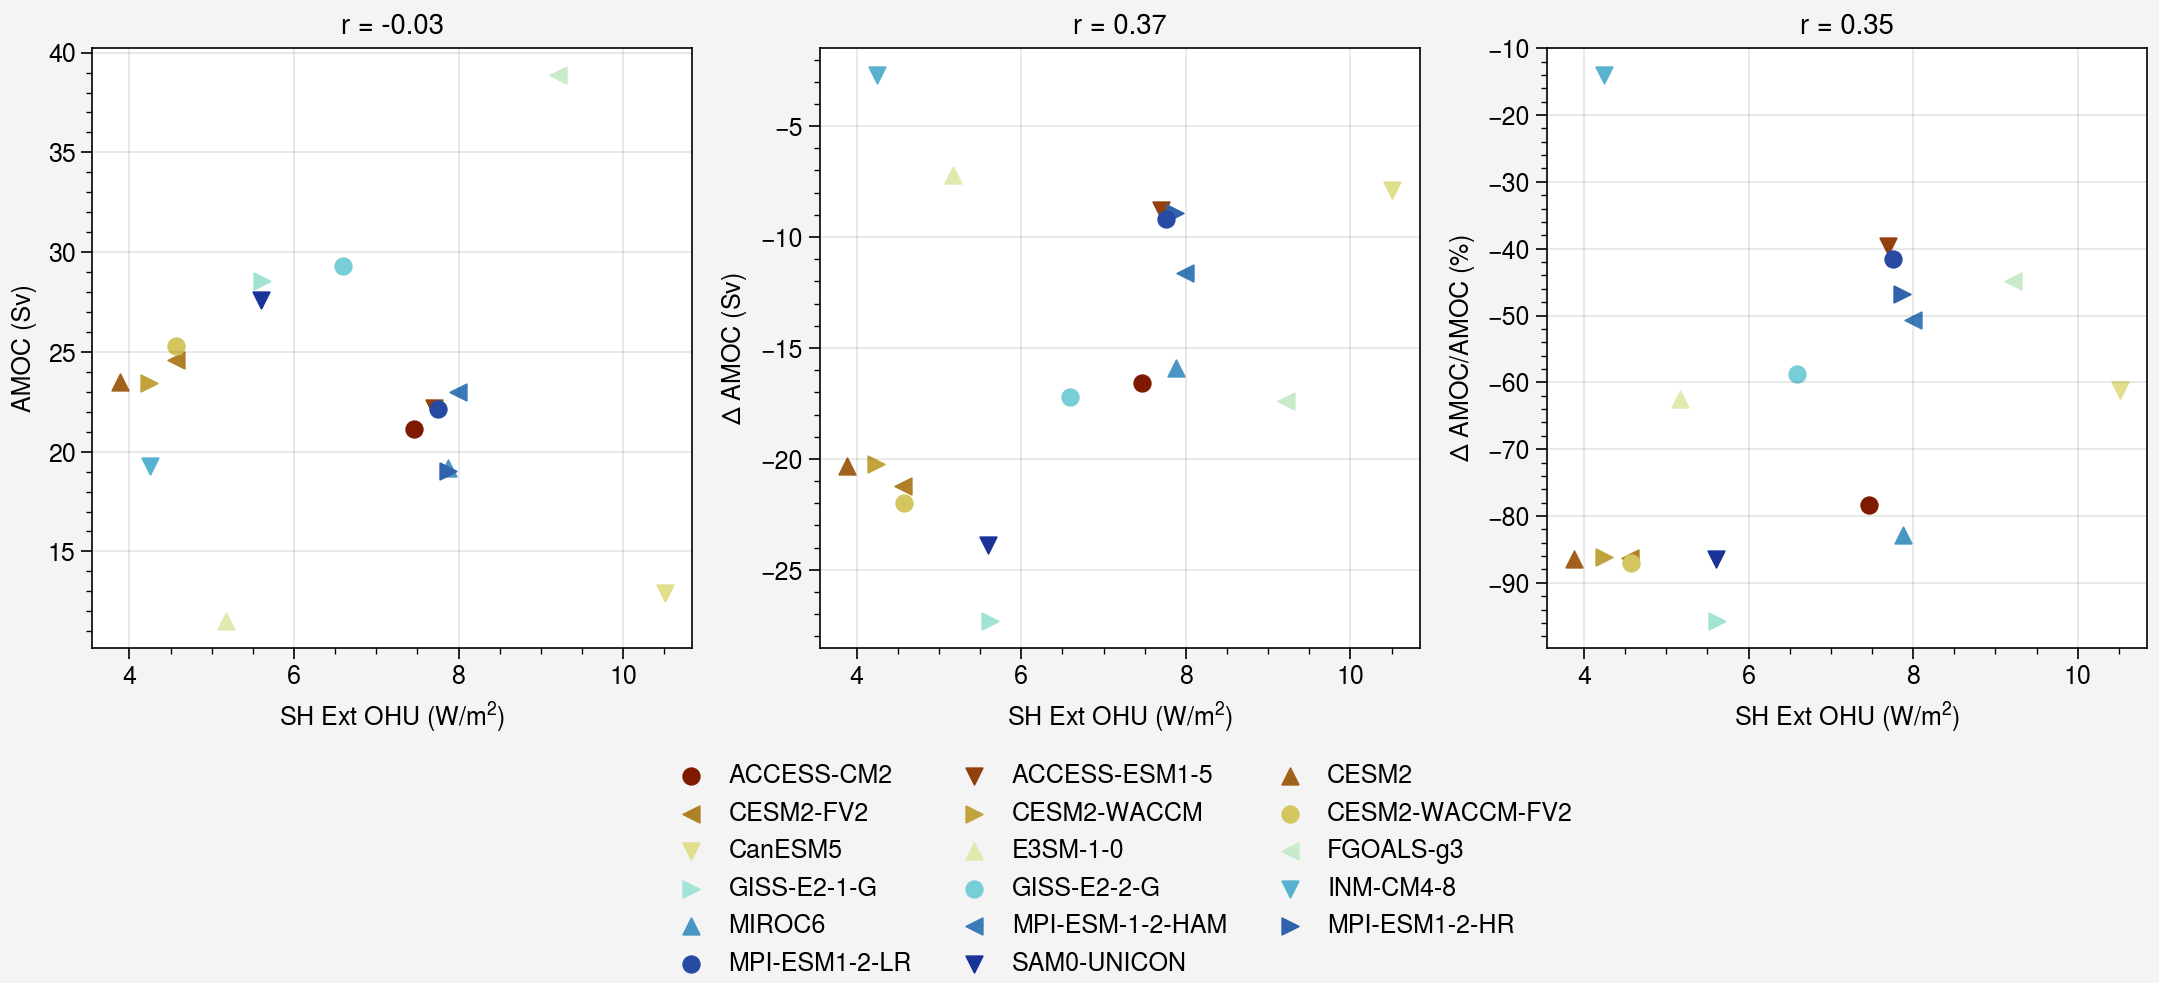

In [89]:
#Make some scatters
fig = pplt.figure(refwidth=3., refaspect=(3, 3), share=False)
cycle = pplt.Cycle('roma', len(modellist), marker=['o','v','^','<','>'])
slope0, intercept0, r_value0, p_value, std_err = scipy.stats.linregress(mydOHU_SH, myAMOCpiC)
slope1, intercept1, r_value1, p_value, std_err = scipy.stats.linregress(mydOHU_SH, mydAMOC)
slope2, intercept2, r_value2, p_value, std_err = scipy.stats.linregress(mydOHU_SH, mydAMOCperc)

ax0 = fig.subplot(131)
ax1 = fig.subplot(132)
ax2 = fig.subplot(133)
for i in enumerate(modellist):
    dOHU_SH = dict_SHext_OHU_anom[i[1]]
    AMOC_piC = AMOCind_piC[i[1]]
    AMOC_ab4XCO2 = AMOCind_ab4XCO2[i[1]]
    dAMOC = AMOC_ab4XCO2-AMOC_piC
    dAMOCperc = 100.*dAMOC/AMOC_piC
    ax0.scatter(dOHU_SH, AMOC_piC, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]], label=i[1])
    ax1.scatter(dOHU_SH, dAMOC, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]])
    ax2.scatter(dOHU_SH, dAMOCperc, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]])

ax0.format(ylabel="AMOC (Sv)",xlabel="SH Ext OHU (W/m$^2$)", title="r = "+str(np.round(r_value0,2)))
ax1.format(ylabel="$\Delta$ AMOC (Sv)",xlabel="SH Ext OHU (W/m$^2$)", title="r = "+str(np.round(r_value1,2)))
ax2.format(ylabel="$\Delta$ AMOC/AMOC (%)",xlabel="SH Ext OHU (W/m$^2$)", title="r = "+str(np.round(r_value2,2)))

fig.legend(ncols=3, frame=False, loc='b')
plt.savefig("CMIP6_SHextOHU_AMOC_Scatter_052022.pdf")

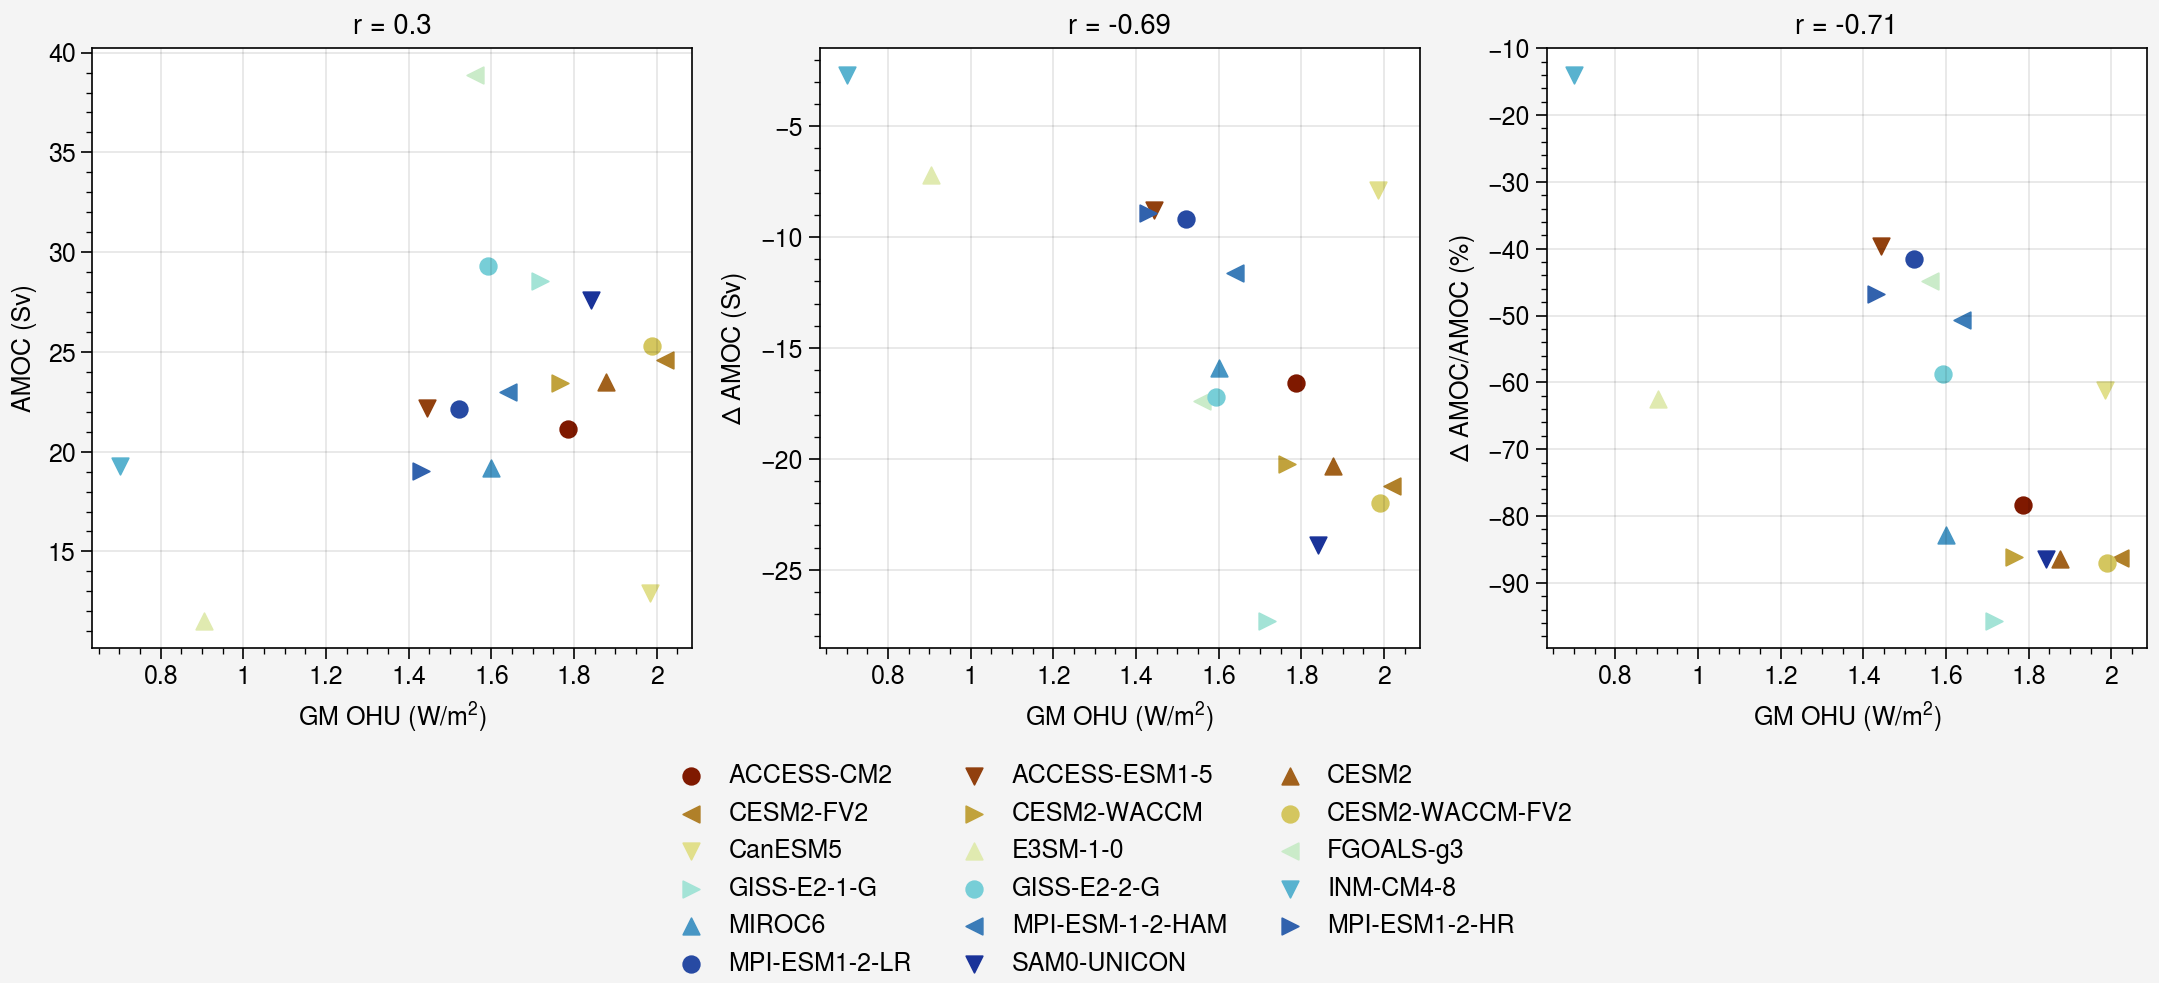

In [90]:
#Make some scatters
fig = pplt.figure(refwidth=3., refaspect=(3, 3), share=False)
cycle = pplt.Cycle('roma', len(modellist), marker=['o','v','^','<','>'])
slope0, intercept0, r_value0, p_value, std_err = scipy.stats.linregress(mydOHU_glob, myAMOCpiC)
slope1, intercept1, r_value1, p_value, std_err = scipy.stats.linregress(mydOHU_glob, mydAMOC)
slope2, intercept2, r_value2, p_value, std_err = scipy.stats.linregress(mydOHU_glob, mydAMOCperc)

ax0 = fig.subplot(131)
ax1 = fig.subplot(132)
ax2 = fig.subplot(133)
for i in enumerate(modellist):
    dOHU_GM = dict_GM_OHU_anom[i[1]]
    AMOC_piC = AMOCind_piC[i[1]]
    AMOC_ab4XCO2 = AMOCind_ab4XCO2[i[1]]
    dAMOC = AMOC_ab4XCO2-AMOC_piC
    dAMOCperc = 100.*dAMOC/AMOC_piC
    ax0.scatter(dOHU_GM, AMOC_piC, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]], label=i[1])
    ax1.scatter(dOHU_GM, dAMOC, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]])
    ax2.scatter(dOHU_GM, dAMOCperc, color=cycle.by_key()['color'][i[0]],\
                marker=cycle.by_key()['marker'][i[0]])

ax0.format(ylabel="AMOC (Sv)",xlabel="GM OHU (W/m$^2$)", title="r = "+str(np.round(r_value0,2)))
ax1.format(ylabel="$\Delta$ AMOC (Sv)",xlabel="GM OHU (W/m$^2$)", title="r = "+str(np.round(r_value1,2)))
ax2.format(ylabel="$\Delta$ AMOC/AMOC (%)",xlabel="GM OHU (W/m$^2$)", title="r = "+str(np.round(r_value2,2)))

fig.legend(ncols=3, frame=False, loc='b')
plt.savefig("CMIP6_globOHU_AMOC_Scatter_052022.pdf")